In [73]:
!pip install torch torch_geometric torch_sparse torch_scatter torch_cluster torch_spline_conv

In [74]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn.models import GAE
from sklearn.metrics import roc_auc_score, average_precision_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [75]:
import numpy as np
import networkx as nx
import math

def pyg_to_nx(data):
    G = nx.Graph()
    edge_index = data.edge_index.cpu().numpy()
    G.add_nodes_from(range(data.num_nodes))
    G.add_edges_from(edge_index.T.tolist())
    return G

In [76]:
#Local heuristics
def common_neighbors_score(G, u, v):
    return len(set(G.neighbors(u)) & set(G.neighbors(v)))

def jaccard_score(G, u, v):
    nu, nv = set(G.neighbors(u)), set(G.neighbors(v))
    if not nu|nv: return 0.0
    return len(nu&nv) / len(nu|nv)

def adamic_adar_score(G, u, v):
    score = 0.0
    for w in set(G.neighbors(u)) & set(G.neighbors(v)):
        deg = G.degree(w)
        if deg>1: score += 1.0 / math.log(deg)
    return score

#Global heuristics
def katz_index_matrix(G, beta=0.05, max_iter=5):
    A = nx.to_numpy_array(G)
    N = A.shape[0]
    K = np.zeros((N,N))
    A_power = A.copy()
    for l in range(1, max_iter+1):
        K += (beta**l) * A_power
        A_power = A.dot(A_power)
    return K

def personalized_pagerank(G, source, alpha=0.85, tol=1e-6, max_iter=100):
    N = G.number_of_nodes()
    A = nx.to_numpy_array(G)
    row_sum = A.sum(axis=1); row_sum[row_sum==0]=1
    P = A / row_sum[:,None]
    r = np.zeros(N); r[source]=1.0
    p = r.copy()
    for _ in range(max_iter):
        p_new = alpha*r + (1-alpha)*p.dot(P)
        if np.linalg.norm(p_new-p,1)<tol: break
        p=p_new
    return p

In [77]:
dataset = Planetoid(root='.', name='CiteSeer')
data = dataset[0]
split = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, add_negative_train_samples=False)
train_data, val_data, test_data = split(data)
G_train = pyg_to_nx(train_data)

In [78]:
edge_index = test_data.edge_label_index.cpu()
edge_label = test_data.edge_label.cpu()

pairs = edge_index.t().numpy()
y_true = edge_label.numpy().tolist()

N = G_train.number_of_nodes()

cn_scores = [common_neighbors_score(G_train, u, v) for u,v in pairs]
jc_scores = [jaccard_score(G_train, u, v)         for u,v in pairs]
aa_scores = [adamic_adar_score(G_train, u, v)     for u,v in pairs]

K = katz_index_matrix(G_train, beta=0.05, max_iter=4)
katz_scores = [
    K[u, v] if u < N and v < N else 0.0
    for u, v in pairs
]

rwr_cache = {}
def get_rwr(u):
    if u not in rwr_cache:
        rwr_cache[u] = personalized_pagerank(G_train, u, alpha=0.85)
    return rwr_cache[u]

rwr_scores = [
    (get_rwr(u)[v] + get_rwr(v)[u]) / 2.0
    for u, v in pairs
]

In [79]:
from sklearn.metrics import roc_auc_score, average_precision_score

methods = [
    "Common Neighbors",
    "Jaccard",
    "Adamic-Adar",
    "Katz",
    "Random Walk w/ Restart (RWR)",
]
scores = [
    cn_scores,
    jc_scores,
    aa_scores,
    katz_scores,
    rwr_scores,
]

print(f"{'Method':35s} {'AUC':>6s}   {'AP':>6s}")
print("-"*50)
for name, sc in zip(methods, scores):
    auc = roc_auc_score(y_true, sc)
    ap  = average_precision_score(y_true, sc)
    print(f"{name:35s} {auc:6.4f}   {ap:6.4f}")


Method                                 AUC       AP
--------------------------------------------------
Common Neighbors                    0.6709   0.6696
Jaccard                             0.6706   0.6696
Adamic-Adar                         0.6715   0.6734
Katz                                0.7583   0.7585
Random Walk w/ Restart (RWR)        0.7699   0.7843


In [80]:
dataset = Planetoid(root="data", name="CiteSeer", transform=None)
data = dataset[0]

# 85/5/10 % edge split with negative sampling
transform = RandomLinkSplit(num_val=0.05,
                            num_test=0.10,
                            is_undirected=True,
                            split_labels=True)     # returns separate positive/negative edges
train_data, val_data, test_data = transform(data)
train_data, val_data, test_data = [d.to(device) for d in (train_data,
                                                          val_data,
                                                          test_data)]


In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE

class Encoder(nn.Module):
    def __init__(self, in_c, hid_c, out_c):
        super().__init__()
        self.conv1 = GCNConv(in_c, hid_c)
        self.conv2 = GCNConv(hid_c, out_c)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)


class GAELinkPredictor(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int = 64,
        latent_dim: int = 32,
        lr: float = 1e-2,
        weight_decay: float = 5e-4,
        device: torch.device | str = "cpu",
    ):
        super().__init__()
        self.device = torch.device(device)


        self.gae = GAE(
            Encoder(in_channels, hidden_channels, latent_dim)
        ).to(self.device)

        self.optimiser = torch.optim.Adam(
            self.gae.parameters(), lr=lr, weight_decay=weight_decay
        )

    def train_epoch(self, data) -> float:
        """One optimisation step; returns reconstruction loss."""
        data = data.to(self.device)

        self.gae.train()
        self.optimiser.zero_grad()

        z = self.gae.encode(data.x, data.edge_index)
        loss = self.gae.recon_loss(
            z,
            pos_edge_index=data.pos_edge_label_index,
            neg_edge_index=data.neg_edge_label_index,
        )
        loss.backward()
        self.optimiser.step()
        return float(loss)

    @torch.no_grad()
    def evaluate(self, data):
        """Return AUC, AP on supplied split (val / test)."""
        data = data.to(self.device)

        self.gae.eval()
        z = self.gae.encode(data.x, data.edge_index)
        auc, ap = self.gae.test(
            z,
            pos_edge_index=data.pos_edge_label_index,
            neg_edge_index=data.neg_edge_label_index,
        )
        return float(auc), float(ap)

    def fit(
        self,
        train_data,
        val_data,
        test_data,
        epochs: int = 300,
        log_every: int = 10,
        patience=20,
    ):
        """
        Train for `epochs`, log every `log_every`, and return a list
        of metric dicts:
            [{'val_auc': ..., 'val_ap': ..., 'test_auc': ..., 'test_ap': ...}, …]
        """
        metrics: list[dict] = []
        bad = 0
        best = 0
        for epoch in range(1, epochs + 1):
            loss = self.train_epoch(train_data)

            if epoch % log_every == 0:
                v_auc, v_ap = self.evaluate(val_data)
                t_auc, t_ap = self.evaluate(test_data)

                print(
                    f"Ep{epoch:03d}  loss={loss:.4f}  "
                    f"val AUC/AP={v_auc:.4f}/{v_ap:.4f}  "
                    f"test AUC/AP={t_auc:.4f}/{t_ap:.4f}"
                )

                metrics.append(
                    {
                        "GAE val_auc":  v_auc,
                        "GAE val_ap":   v_ap,
                        "GAE test_auc": t_auc,
                        "GAE test_ap":  t_ap,
                    }
                )

                if v_auc > best:
                    best = v_auc
                    torch.save(model.state_dict(), "best_gae_citeseer.pt")
                    bad = 0
                else:
                    bad += 1
                    if bad == patience:
                        print("Early stop."); break

        return metrics


In [82]:
model = GAELinkPredictor(
    dataset.num_node_features,
       hidden_channels=64,
       latent_dim=32
)

metrics = model.fit(
    train_data,
    val_data,
    test_data,
    epochs=300,
    log_every=10
)

Ep010  loss=1.0973  val AUC/AP=0.8466/0.8591  test AUC/AP=0.8355/0.8403
Ep020  loss=0.7371  val AUC/AP=0.8675/0.8807  test AUC/AP=0.8643/0.8738
Ep030  loss=0.4441  val AUC/AP=0.8686/0.8787  test AUC/AP=0.8620/0.8745
Ep040  loss=0.2199  val AUC/AP=0.8466/0.8564  test AUC/AP=0.8481/0.8648
Ep050  loss=0.0963  val AUC/AP=0.8479/0.8562  test AUC/AP=0.8359/0.8498
Ep060  loss=0.0441  val AUC/AP=0.8534/0.8581  test AUC/AP=0.8296/0.8383
Ep070  loss=0.0279  val AUC/AP=0.8617/0.8692  test AUC/AP=0.8368/0.8443
Ep080  loss=0.0236  val AUC/AP=0.8651/0.8732  test AUC/AP=0.8394/0.8470
Ep090  loss=0.0211  val AUC/AP=0.8663/0.8739  test AUC/AP=0.8395/0.8466
Ep100  loss=0.0184  val AUC/AP=0.8638/0.8683  test AUC/AP=0.8383/0.8459
Ep110  loss=0.0161  val AUC/AP=0.8624/0.8686  test AUC/AP=0.8376/0.8469
Ep120  loss=0.0145  val AUC/AP=0.8603/0.8680  test AUC/AP=0.8356/0.8429
Ep130  loss=0.0134  val AUC/AP=0.8583/0.8661  test AUC/AP=0.8345/0.8422
Ep140  loss=0.0124  val AUC/AP=0.8556/0.8623  test AUC/AP=0.8336

In [83]:
model.load_state_dict(torch.load("best_gae_citeseer.pt"))
final_auc, final_ap = model.evaluate(test_data)
print(f"\nBest model ‑‑ Test AUC: {final_auc:.4f} | AP: {final_ap:.4f}")



Best model ‑‑ Test AUC: 0.8620 | AP: 0.8745


In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import roc_auc_score, average_precision_score


class GraphSAGELinkPredictor(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden: int = 128,
        lr: float = 5e-3,
        weight_decay: float = 1e-4,
        device: str | torch.device = "cpu",
    ):
        super().__init__()
        self.device = torch.device(device)

        # encoder layers
        self.sage1 = SAGEConv(in_channels, hidden)
        self.sage2 = SAGEConv(hidden, hidden)

        # optimiser
        self.opt = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        self.to(self.device)


    def encode(self, x, edge_index):
        x = F.relu(self.sage1(x, edge_index))
        return self.sage2(x, edge_index)

    @staticmethod
    def decode(z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)


    def train_epoch(self, data) -> float:
        """One gradient step on `data` (expects pos/neg edge labels)."""
        data = data.to(self.device)
        self.train()
        self.opt.zero_grad()

        z = self.encode(data.x, data.edge_index)
        pos_logit = self.decode(z, data.pos_edge_label_index)
        neg_logit = self.decode(z, data.neg_edge_label_index)

        y_true = torch.cat(
            [torch.ones_like(pos_logit), torch.zeros_like(neg_logit)]
        )
        logits = torch.cat([pos_logit, neg_logit])

        loss = F.binary_cross_entropy_with_logits(logits, y_true)
        loss.backward()
        self.opt.step()
        return float(loss)

    @torch.no_grad()
    def eval_epoch(self, data):
        """Return (AUC, AP) on `data`."""
        data = data.to(self.device)
        self.eval()

        z = self.encode(data.x, data.edge_index)
        pos = self.decode(z, data.pos_edge_label_index).sigmoid().cpu()
        neg = self.decode(z, data.neg_edge_label_index).sigmoid().cpu()

        y_pred = torch.cat([pos, neg])
        y_true = torch.cat([torch.ones_like(pos), torch.zeros_like(neg)])

        auc = roc_auc_score(y_true, y_pred)
        ap = average_precision_score(y_true, y_pred)
        return float(auc), float(ap)


    def fit(
        self,
        train_data,
        val_data,
        test_data,
        metrics: list = [],
        epochs: int = 300,
        log_every: int = 10,
        patience: int = 20,
        ckpt_path: str = "best_sage_citeseer.pt",
    ):
        """
        Train with early stopping. Returns a list of metric dicts collected
        every `log_every` epochs.
        """
        best_val_auc, bad = -float("inf"), 0
        idx_metrics = 0
        for epoch in range(1, epochs + 1):
            loss = self.train_epoch(train_data)

            if epoch % log_every == 0:
                v_auc, v_ap = self.eval_epoch(val_data)
                t_auc, t_ap = self.eval_epoch(test_data)

                print(
                    f"Ep{epoch:03d}  loss={loss:.4f}  "
                    f"val AUC/AP={v_auc:.4f}/{v_ap:.4f}  "
                    f"test AUC/AP={t_auc:.4f}/{t_ap:.4f}"
                )
                if len(metrics) <= idx_metrics:
                    metrics.append({
                        "GraphSAGE val AUC": v_auc,
                        "GraphSAGE val AP": v_ap,
                        "GraphSAGE test AUC": t_auc,
                        "GraphSAGE test AP": t_ap,
                    })
                else:
                    metrics[idx_metrics].update({
                        "GraphSAGE val AUC": v_auc,
                        "GraphSAGE val AP": v_ap,
                        "GraphSAGE test AUC": t_auc,
                        "GraphSAGE test AP": t_ap,
                    })

                idx_metrics += 1
                if v_auc > best_val_auc:
                    best_val_auc, bad = v_auc, 0
                    torch.save(self.state_dict(), ckpt_path)
                else:
                    bad += 1
                    if bad == patience:
                        print("Early stop."); break


        # load & report best
        self.load_state_dict(torch.load(ckpt_path))
        best_auc, best_ap = self.eval_epoch(test_data)
        print(f"\nBest model → Test AUC={best_auc:.4f}  AP={best_ap:.4f}")
        return metrics


In [85]:
model = GraphSAGELinkPredictor(
    dataset.num_node_features,
    hidden=64,
)

metrics = model.fit(
    train_data,
    val_data,
    test_data,
    epochs=300,
    log_every=10,
    metrics = metrics
)

Ep010  loss=0.3685  val AUC/AP=0.8294/0.8297  test AUC/AP=0.8453/0.8557
Ep020  loss=0.0912  val AUC/AP=0.8012/0.7790  test AUC/AP=0.8246/0.8328
Ep030  loss=0.0063  val AUC/AP=0.7812/0.7442  test AUC/AP=0.7994/0.7713
Ep040  loss=0.0008  val AUC/AP=0.7769/0.7317  test AUC/AP=0.7853/0.7399
Ep050  loss=0.0004  val AUC/AP=0.7799/0.7333  test AUC/AP=0.7871/0.7417
Ep060  loss=0.0003  val AUC/AP=0.7875/0.7444  test AUC/AP=0.7957/0.7548
Ep070  loss=0.0004  val AUC/AP=0.7971/0.7603  test AUC/AP=0.8048/0.7673
Ep080  loss=0.0006  val AUC/AP=0.8051/0.7753  test AUC/AP=0.8169/0.7910
Ep090  loss=0.0008  val AUC/AP=0.8097/0.7810  test AUC/AP=0.8229/0.8028
Ep100  loss=0.0008  val AUC/AP=0.8131/0.7848  test AUC/AP=0.8287/0.8172
Ep110  loss=0.0008  val AUC/AP=0.8154/0.7861  test AUC/AP=0.8312/0.8232
Ep120  loss=0.0007  val AUC/AP=0.8162/0.7856  test AUC/AP=0.8320/0.8255
Ep130  loss=0.0007  val AUC/AP=0.8161/0.7853  test AUC/AP=0.8328/0.8282
Ep140  loss=0.0006  val AUC/AP=0.8165/0.7874  test AUC/AP=0.8318

In [86]:
import pandas as pd
metrics_df = pd.DataFrame(metrics)

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_seaborn_link_metrics(df):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # --- Validation ---
    sns.lineplot(ax=axes[0], data=df, x=df.index, y="GAE val_auc", marker="o", label="GAE val AUC")
    sns.lineplot(ax=axes[0], data=df, x=df.index, y="GAE val_ap",  marker="o", label="GAE val AP")
    sns.lineplot(ax=axes[0], data=df, x=df.index, y="GraphSAGE val AUC", marker="o", label="GraphSAGE val AUC")
    sns.lineplot(ax=axes[0], data=df, x=df.index, y="GraphSAGE val AP", marker="o", label="GraphSAGE val AP")
    axes[0].set_title("Validation metrics across runs")
    axes[0].set_xlabel("Run / seed")
    axes[0].set_ylabel("Score")
    axes[0].legend()

    # --- Test ---
    sns.lineplot(ax=axes[1], data=df, x=df.index, y="GAE test_auc", marker="o", label="GAE test AUC")
    sns.lineplot(ax=axes[1], data=df, x=df.index, y="GAE test_ap",  marker="o", label="GAE test AP")
    sns.lineplot(ax=axes[1], data=df, x=df.index, y="GraphSAGE test AUC", marker="o", label="GraphSAGE test AUC")
    sns.lineplot(ax=axes[1], data=df, x=df.index, y="GraphSAGE test AP", marker="o", label="GraphSAGE test AP")
    axes[1].set_title("Test metrics across runs")
    axes[1].set_xlabel("Run / seed")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


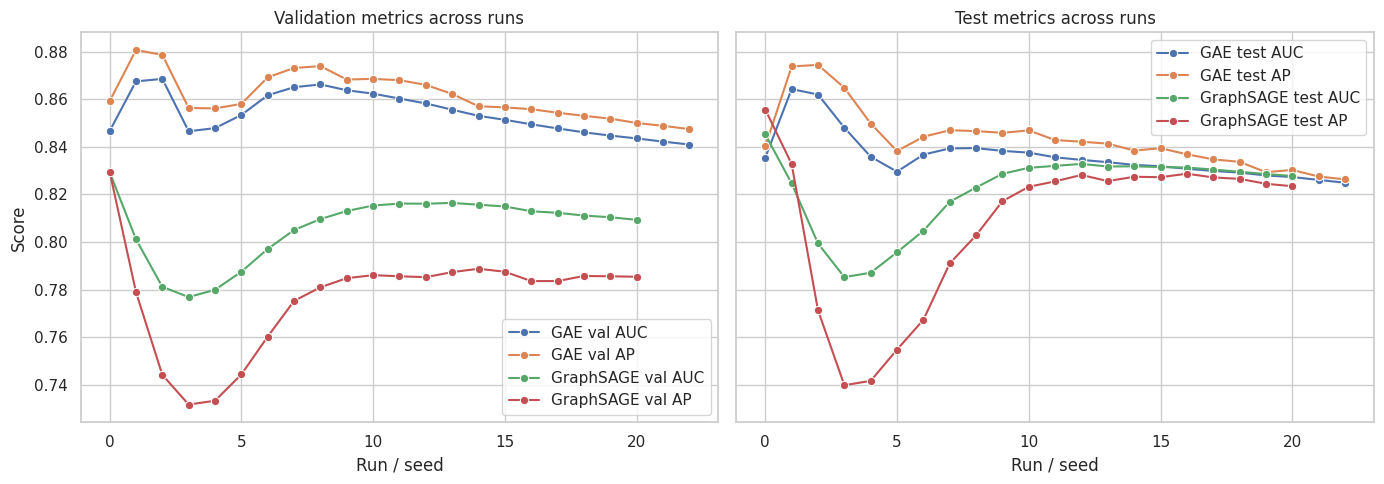

In [88]:
plot_seaborn_link_metrics(metrics_df)